# Évaluation des modèles de classification

## Imports

In [2]:
import os
import torch
import timm
import pandas as pd
import numpy as np
from timm.data.transforms_factory import create_transform
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import ThreeViewsDataset, FrontViewDataset 
import options

## Fonctions

In [3]:
def load_dataset(split_dir, split, test_folds, image_dir, transform):
    test_df = pd.concat([pd.read_csv(os.path.join(split_dir, split, split + f'_fold_{i}.csv')) for i in test_folds], axis=0)
    test_dataset = MyDataset(test_df.values, image_dir, transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    return test_loader

In [4]:
def load_model(model_name, in_channels, num_classes, model_path):
    model = timm.create_model(model_name, pretrained=False, in_chans=in_channels, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model = model.to('cpu')
    
    model.eval()

    return model

In [5]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    list_predictions = []
    list_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs, targets
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            list_predictions.append(predicted[0].item())
            list_targets.append(targets[0].item())
    
    
    accuracy = correct / total

    # true_positive_per_class = [0] * model.num_classes
    # targets_per_class = [0] * model.num_classes
    # for pred, targ in zip(list_predictions, list_targets):
    #     targets_per_class[targ] += 1
    #     if pred == targ:
    #         true_positive_per_class[targ] += 1
        
    # recall = mean([tp/tot for tp, tot in zip(true_positive_per_class, targets_per_class)])
    # precision = 

    
    # print('Accuracy: {:.3f}%'.format(accuracy))
    # print('Recall: {:.3f}%'.format(recall))
    # print('Precision: {:.3f}%'.format(precision))
    
    return accuracy, list_predictions, list_targets

In [6]:
def plot_confusion_matrix(predictions, targets):
    index_to_label = {
            0: 'ecto',
            1: 'ecto-meso',
            2: 'meso',
            3: 'meso-endo',
            4: 'endo'
            }

    # Convert numerical predictions and targets to class names
    predictions_class_names = [index_to_label[pred] for pred in predictions]
    targets_class_names = [index_to_label[target] for target in targets]

    # Compute confusion matrix
    cm = confusion_matrix(targets_class_names, predictions_class_names, labels=list(label_to_index.keys()))
    
    # Create a DataFrame for the confusion matrix
    cm_df = pd.DataFrame(cm, index=list(label_to_index.keys()), columns=list(label_to_index.keys()))

    # Calculer l'exactitude
    accuracy = np.trace(cm) / np.sum(cm)

    # # Calculer la précision et le rappel globaux
    # precision_global = np.sum(np.diag(cm) / np.sum(cm.sum(axis=0))) / np.diag(cm).shape[0]
    # recall_global = np.sum(np.diag(cm) / np.sum(cm.sum(axis=1))) / np.diag(cm).shape[0]
    
    # Afficher les résultats
    print(f'Accuracy: {accuracy:.3f}')
    # print(f'Global Precision: {precision_global:.2f}')
    # print(f'Global Recall: {recall_global:.2f}')

    
    
    # Calculer la précision et le rappel pour chaque classe
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)

    print(f'Mean precision: {np.mean(precision):.3f}')
    print(f'Mean recall: {np.mean(recall):.3f}')

    print('---')
    # Afficher les résultats
    # print(f'Accuracy: {accuracy:.3f}')
    for i, label in enumerate(label_to_index.keys()):
        print(f'{label} - precision: {precision[i]:.3f}, recall: {recall[i]:.3f}')
        # print(f'Precision for {label}: {precision[i]:.3f}')
        # print(f'Recall for {label}: {recall[i]:.3f}')
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

## Variables globales

In [7]:
image_dir_batch1 = r'C:\Users\Daniel\Documents\Data\MORPHO_Batch1'
split_dir = r'C:\Users\Daniel\Documents\Workspace\ClinicDataAnalysis\splits'
label_to_index = {
            'ecto': 0, 
            'ecto-meso': 1,
            'meso': 2,
            'meso-endo': 3,
            'endo': 4
            }

index_to_label = {
            0: 'ecto',
            1: 'ecto-meso',
            2: 'meso',
            3: 'meso-endo',
            4: 'endo'
            }

list_datasets = {
    'FrontViewDataset': FrontViewDataset,
    'ThreeViewsDataset': ThreeViewsDataset,
}

## Evaluations

### ResNet50

#### 001

In [7]:
# Variables
model_name = 'resnet50'
model_path = r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs\resnet50_001\model_epoch_26.pth'
split = "full_balanced"
train_folds = [0,1,2,3,4,5,6,7]
val_folds = [8]
test_folds = [9] 
num_classes = 5
in_channels = 3
log_name = model_name + '_' + '001'
MyDataset = FrontViewDataset
transform = create_transform((3,224,224))
drop_rate = 0


# Load Dataset
dataloader = load_dataset(split_dir, split, test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, num_classes, model_path)

# Evaluate model
accuracy, predictions1, targets1 = evaluate_model(model, dataloader)

Accuracy: 0.434
Mean precision: 0.421
Mean recall: 0.432
---
ecto - precision: 0.485, recall: 0.620
ecto-meso - precision: 0.311, recall: 0.280
meso - precision: 0.395, recall: 0.262
meso-endo - precision: 0.411, recall: 0.311
endo - precision: 0.505, recall: 0.685


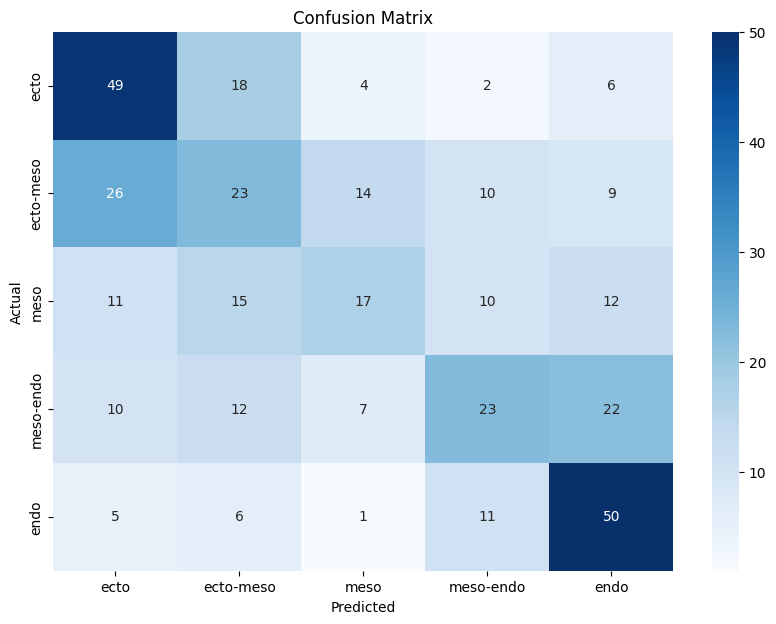

In [8]:
# Trace matrice de confusion
plot_confusion_matrix(predictions1, targets1)

#### 002

In [9]:
# Variables
model_name = 'resnet50'
model_path = r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs\resnet50_002\model_epoch_15.pth'
split = "full_balanced"
train_folds = [0,1,2,3,4,5,6,7]
val_folds = [8]
test_folds = [9] 
num_classes = 5
in_channels = 3
log_name = model_name + '_' + '002'
MyDataset = FrontViewDataset
transform = create_transform((3,320,224))
drop_rate = 0


# Load Dataset
dataloader = load_dataset(split_dir, split, test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, num_classes, model_path)

# Evaluate model
accuracy, predictions2, targets2 = evaluate_model(model, dataloader)



Accuracy: 0.402
Mean precision: 0.380
Mean recall: 0.398
---
ecto - precision: 0.506, recall: 0.532
ecto-meso - precision: 0.297, recall: 0.268
meso - precision: 0.297, recall: 0.169
meso-endo - precision: 0.328, recall: 0.297
endo - precision: 0.473, recall: 0.726


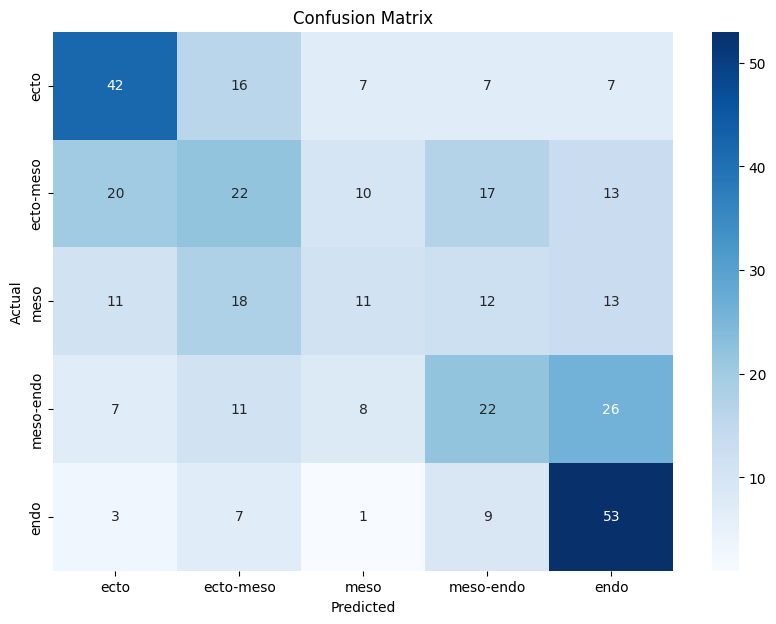

In [10]:
# Trace matrice de confusion
plot_confusion_matrix(predictions2, targets2)

Les tests 001 et 002 semblent atteindre la même conclusion. Avec un simple fine tuning, le modèle semble en difficulté pour correctement classifier les images. Au vu de la matrice de confusion, la classe 'meso' est très mal classifiée. C'est également la classe la moins représentées dans la base de données. On se propose donc dans le test 003 d'utiliser une base de données parfaitement équilibrée. On regardera, lors d'expérimentations futur, le dégèle de l'intégralité du réseau et le traitement des 3 images ou lieu de la première exclusivement. 

#### 003

In [11]:
# Variables
model_name = 'resnet50'
split = "strict_full_balanced"
log_name = model_name + '_' + '003'
weigths = 'model_epoch_19.pth'
train_folds = [0,1,2,3,4,5,6,7]
val_folds = [8]
test_folds = [9] 
num_classes = 5
in_channels = 3
MyDataset = FrontViewDataset
transform = create_transform((3,320,224))
drop_rate = 0
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)

# Load Dataset
dataloader = load_dataset(split_dir, split, test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, num_classes, model_path)

# Evaluate model
accuracy, predictions3, targets3 = evaluate_model(model, dataloader)

Accuracy: 0.443
Mean precision: 0.424
Mean recall: 0.443
---
ecto - precision: 0.479, recall: 0.538
ecto-meso - precision: 0.291, recall: 0.246
meso - precision: 0.418, recall: 0.354
meso-endo - precision: 0.373, recall: 0.292
endo - precision: 0.560, recall: 0.785


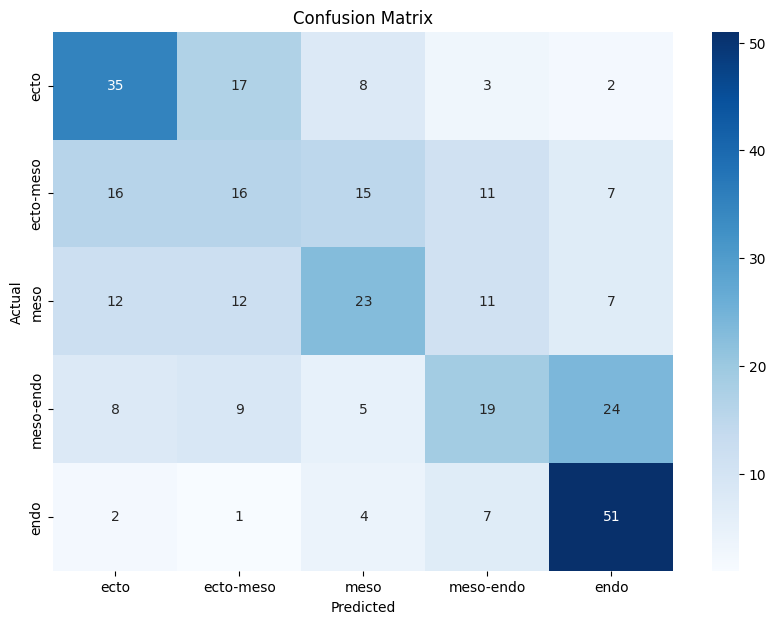

In [12]:
# Trace matrice de confusion
plot_confusion_matrix(predictions3, targets3)

#### 004

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 4, 5, 6, 7], val_folds=[8], test_folds=[9], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_004')
Accuracy: 0.515
Mean precision: 0.524
Mean recall: 0.513
---
ecto - precision: 0.526, recall: 0.646
ecto-meso - precision: 0.492, recall: 0.366
meso - precision: 0.575, recall: 0.354
meso-endo - precision: 0.545, recall: 0.405
endo - precision: 0.483, recall: 0.795


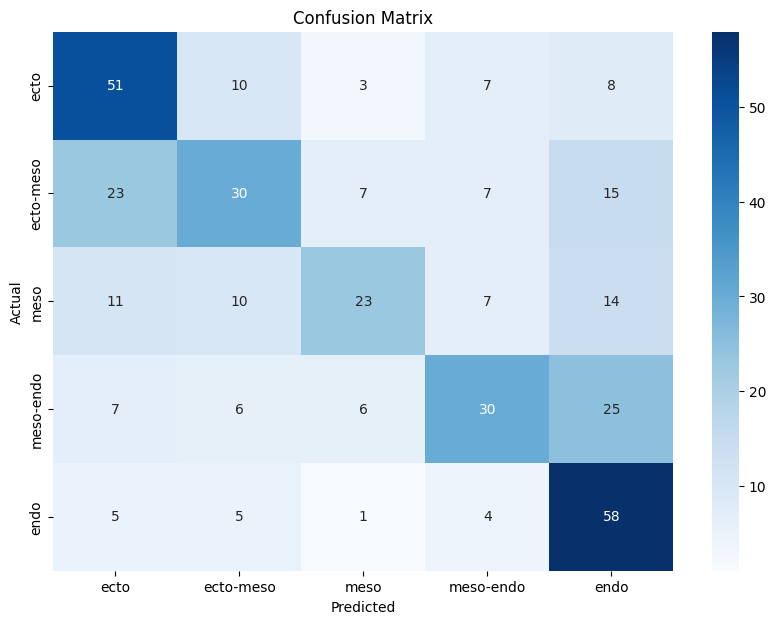

In [16]:
# Variables
model_name = 'resnet50'
split = "full_balanced"
log_name = model_name + '_' + '004'
weigths = 'model_epoch_15.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 005

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[0], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_005')
Accuracy: 0.504
Mean precision: 0.497
Mean recall: 0.494
---
ecto - precision: 0.472, recall: 0.734
ecto-meso - precision: 0.533, recall: 0.482
meso - precision: 0.452, recall: 0.219
meso-endo - precision: 0.471, recall: 0.324
endo - precision: 0.559, recall: 0.712


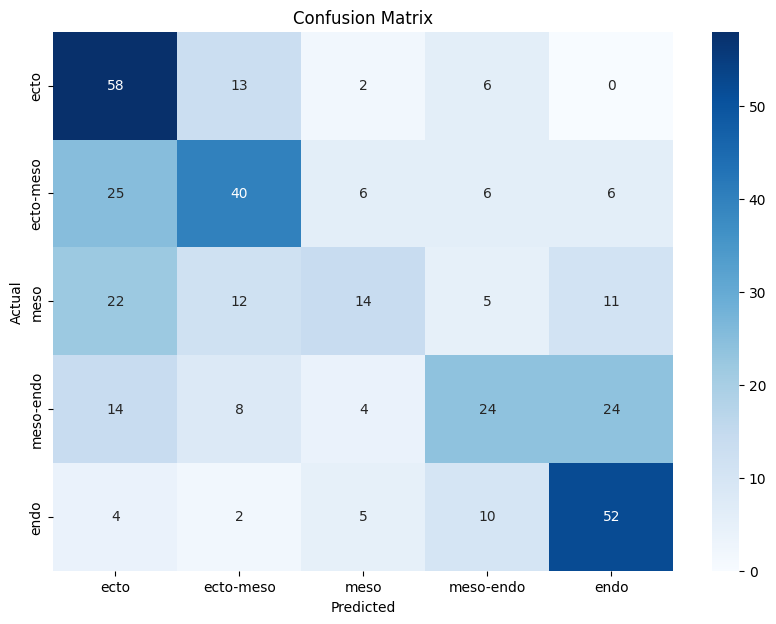

In [17]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '005'
weigths = 'model_epoch_10.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 006

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_006')
Accuracy: 0.542
Mean precision: 0.562
Mean recall: 0.537
---
ecto - precision: 0.570, recall: 0.662
ecto-meso - precision: 0.458, recall: 0.463
meso - precision: 0.703, recall: 0.406
meso-endo - precision: 0.556, recall: 0.342
endo - precision: 0.522, recall: 0.811


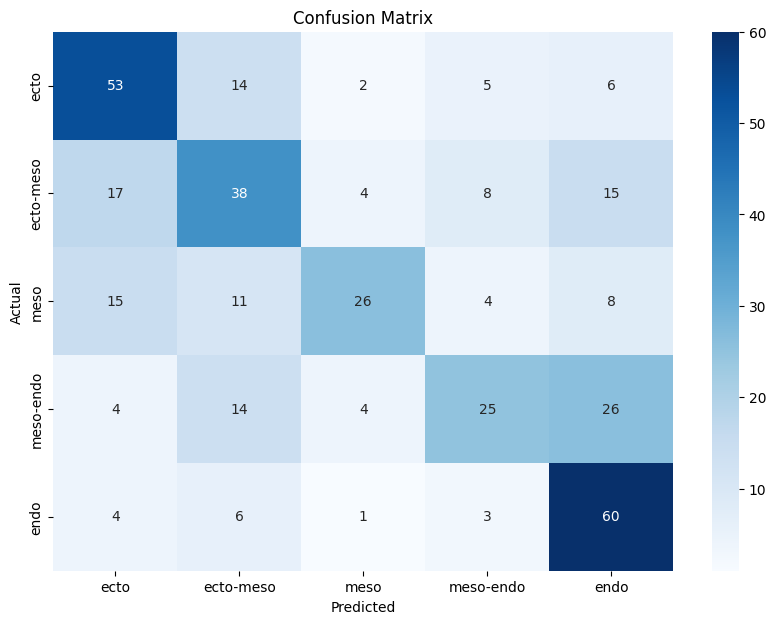

In [15]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '006'
weigths = 'model_epoch_11.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 007

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 4, 6, 7, 8], val_folds=[5], test_folds=[9], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_007')
Accuracy: 0.488
Mean precision: 0.483
Mean recall: 0.485
---
ecto - precision: 0.510, recall: 0.646
ecto-meso - precision: 0.483, recall: 0.341
meso - precision: 0.487, recall: 0.292
meso-endo - precision: 0.433, recall: 0.392
endo - precision: 0.505, recall: 0.753


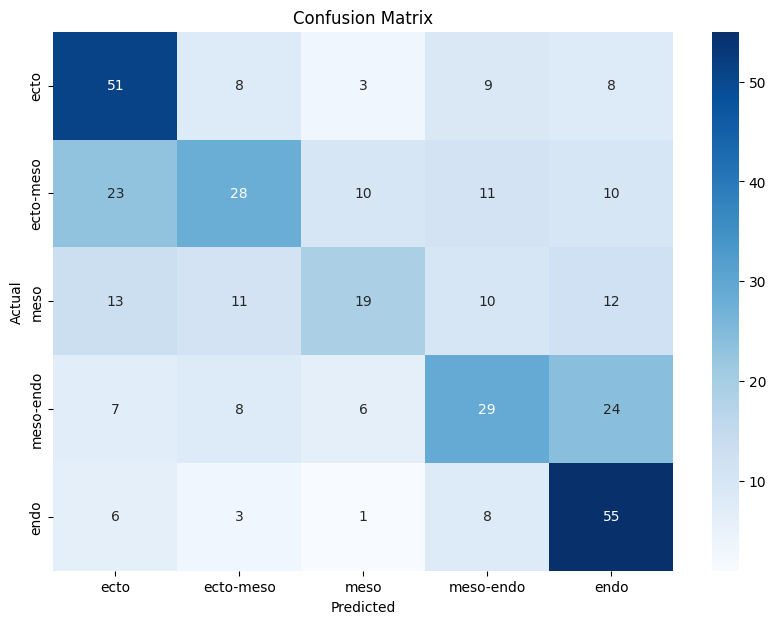

In [18]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '007'
weigths = 'model_epoch_12.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 008

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_008')
Accuracy: 0.517
Mean precision: 0.515
Mean recall: 0.508
---
ecto - precision: 0.531, recall: 0.759
ecto-meso - precision: 0.533, recall: 0.482
meso - precision: 0.533, recall: 0.250
meso-endo - precision: 0.463, recall: 0.338
endo - precision: 0.515, recall: 0.712


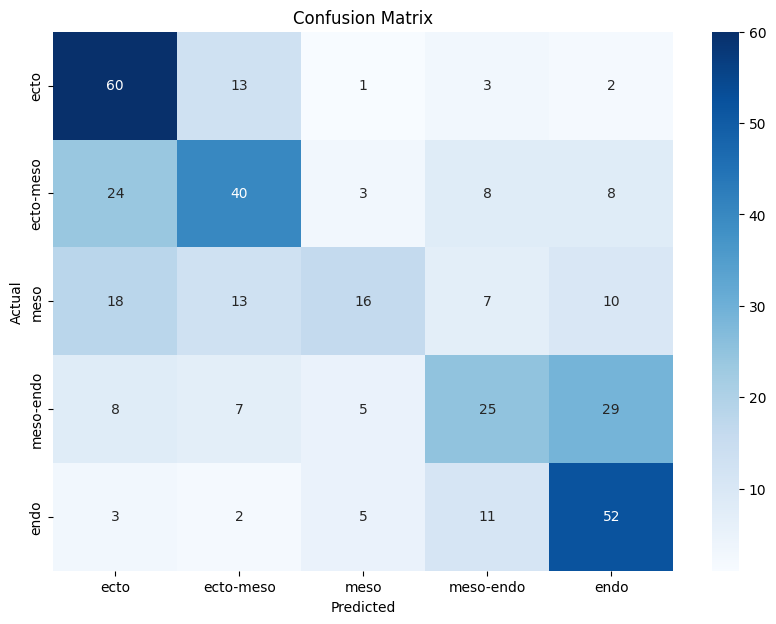

In [20]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '008'
weigths = 'model_epoch_11.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 009

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_009')
Accuracy: 0.501
Mean precision: 0.511
Mean recall: 0.502
---
ecto - precision: 0.583, recall: 0.613
ecto-meso - precision: 0.475, recall: 0.341
meso - precision: 0.493, recall: 0.516
meso-endo - precision: 0.545, recall: 0.164
endo - precision: 0.461, recall: 0.878


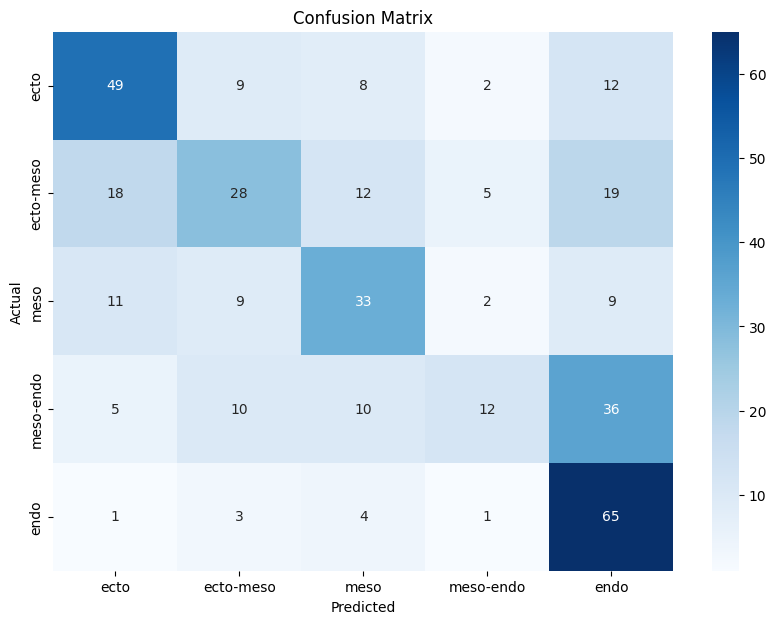

In [21]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '009'
weigths = 'model_epoch_6.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

Au vu des résultats, dégeler tous les paramètres du réseau semble être une bonne solution pour améliorer les performances, avec une amélioration de 10 points. Il est donc à envisager de continuer dans ce sens. D'autre part, il faut explorer l'injection des trois images à l'entrée du réseau, soit via 3*3 cannaux ou bien par la construction d'une grande image incluant les 3 vues sur 3 canneaux. D'autre part, il semble intéressant de moduler le 'early stop' pour permettre au réseau de d'apprendre d'avantage et passer des maximum locaux.

#### 010

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 4, 5, 6, 7], val_folds=[8], test_folds=[9], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_010')
Accuracy: 0.515
Mean precision: 0.524
Mean recall: 0.513
---
ecto - precision: 0.526, recall: 0.646
ecto-meso - precision: 0.492, recall: 0.366
meso - precision: 0.575, recall: 0.354
meso-endo - precision: 0.545, recall: 0.405
endo - precision: 0.483, recall: 0.795


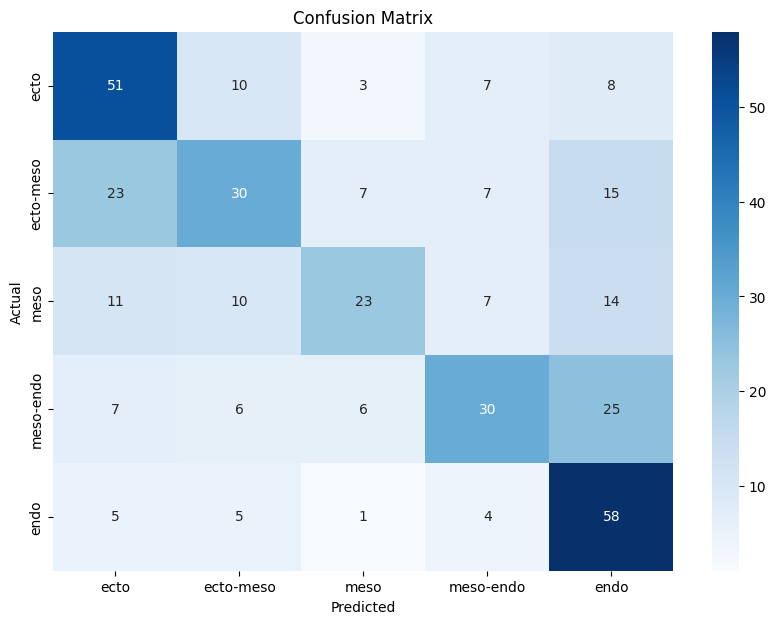

In [22]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '010'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 011

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_011')
Accuracy: 0.517
Mean precision: 0.515
Mean recall: 0.508
---
ecto - precision: 0.531, recall: 0.759
ecto-meso - precision: 0.533, recall: 0.482
meso - precision: 0.533, recall: 0.250
meso-endo - precision: 0.463, recall: 0.338
endo - precision: 0.515, recall: 0.712


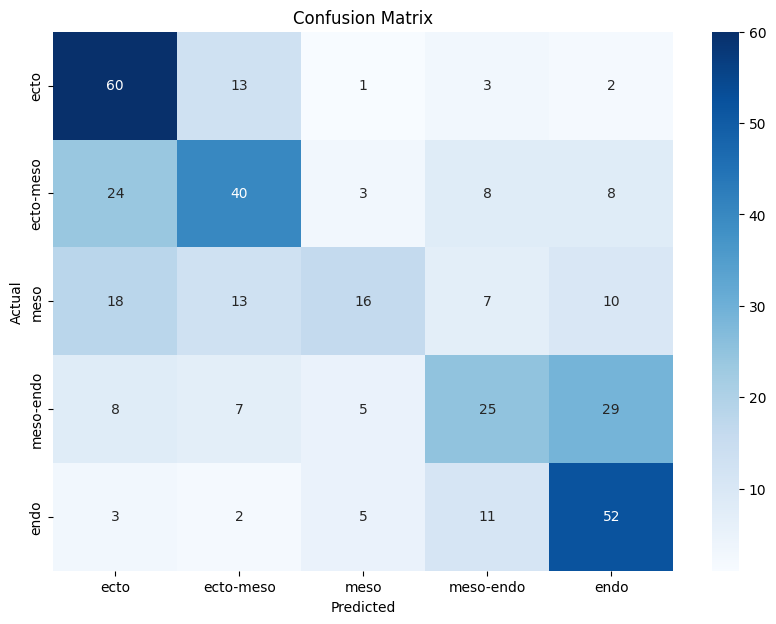

In [23]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '011'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 012

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 4, 5, 6, 8, 9], val_folds=[3], test_folds=[7], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_012')
Accuracy: 0.515
Mean precision: 0.515
Mean recall: 0.509
---
ecto - precision: 0.547, recall: 0.734
ecto-meso - precision: 0.457, recall: 0.395
meso - precision: 0.562, recall: 0.273
meso-endo - precision: 0.485, recall: 0.432
endo - precision: 0.525, recall: 0.712


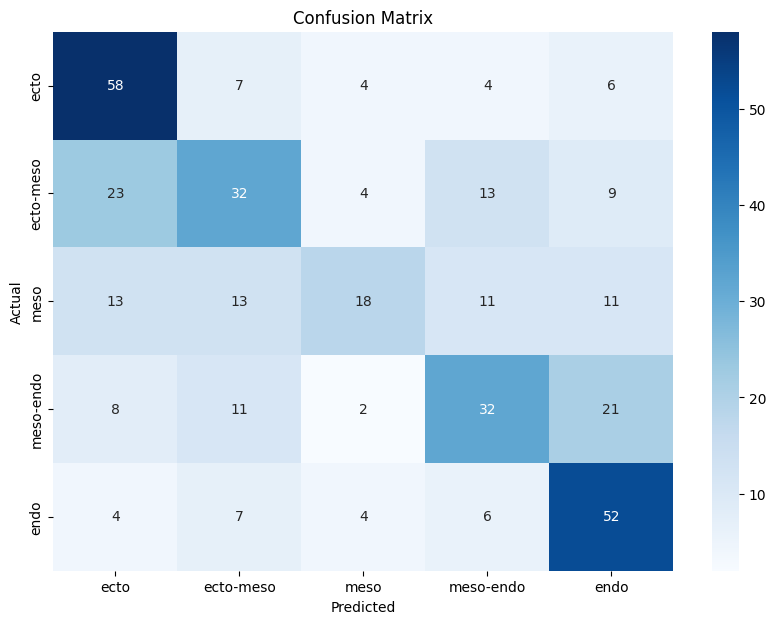

In [24]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '012'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

Pas d'améliorations probantes en augmentant le earlystopping. Ce qu'on va faire, c'est une comparaison avec d'autres modèles, dans le cas le plus favorable de l'entrainement résultant au modèle resnet50_006

### Mobilenetv2_120d

#### 001

In [22]:
# Variables
model_name = 'mobilenetv2_120d'
split = "strict_full_balanced"
log_name = model_name + '_' + '001'
weigths = 'model_epoch_10.pth'
train_folds = [0,1,2,3,4,5,6,7]
val_folds = [8]
test_folds = [9] 
num_classes = 5
in_channels = 3
MyDataset = FrontViewDataset
transform = create_transform((3,320,224))
drop_rate = 0
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)

# Load Dataset
dataloader = load_dataset(split_dir, split, test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, num_classes, model_path)

# Evaluate model
accuracy, predictions4, targets4 = evaluate_model(model, dataloader)

Accuracy: 0.338
Mean precision: 0.342
Mean recall: 0.338
---
ecto - precision: 0.385, recall: 0.462
ecto-meso - precision: 0.188, recall: 0.200
meso - precision: 0.254, recall: 0.246
meso-endo - precision: 0.415, recall: 0.338
endo - precision: 0.468, recall: 0.446


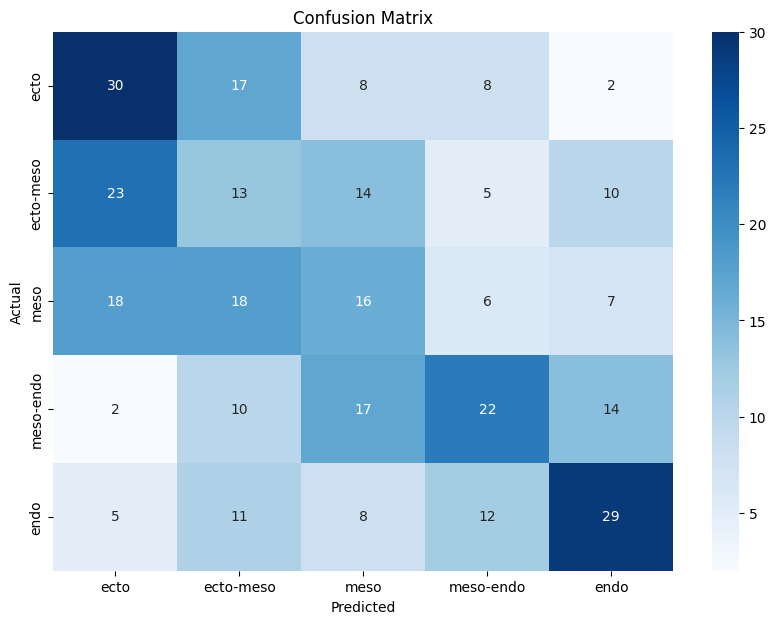

In [23]:
# Trace matrice de confusion
plot_confusion_matrix(predictions4, targets4)

#### 002

Namespace(model_name='mobilenetv2_120d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='mobilenetv2_120d_002')
Accuracy: 0.426
Mean precision: 0.414
Mean recall: 0.422
---
ecto - precision: 0.481, recall: 0.475
ecto-meso - precision: 0.405, recall: 0.390
meso - precision: 0.321, recall: 0.266
meso-endo - precision: 0.375, recall: 0.329
endo - precision: 0.490, recall: 0.649


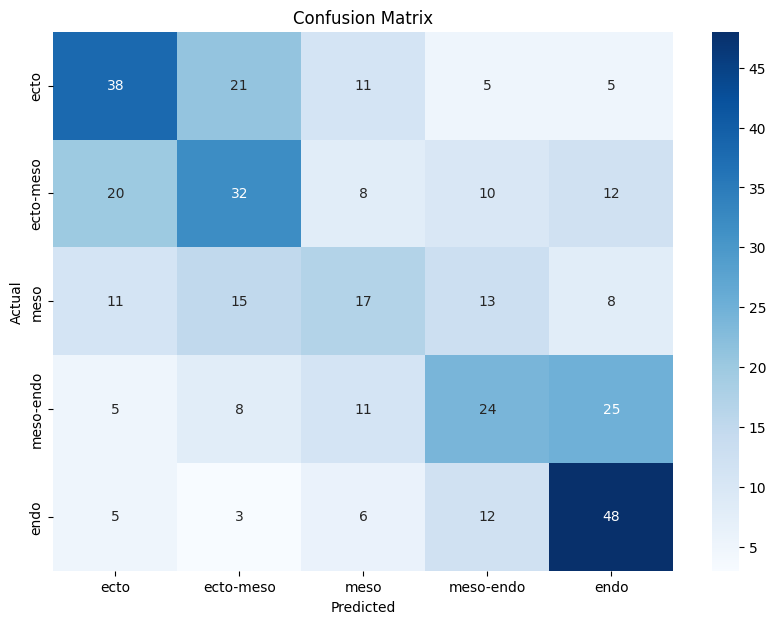

In [24]:
# Variables
model_name = 'mobilenetv2_120d'
log_name = model_name + '_' + '002'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

### ConvNeXt_tiny

#### 001

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_001')
Accuracy: 0.611
Mean precision: 0.611
Mean recall: 0.612
---
ecto - precision: 0.709, recall: 0.762
ecto-meso - precision: 0.493, recall: 0.415
meso - precision: 0.458, recall: 0.594
meso-endo - precision: 0.587, recall: 0.507
endo - precision: 0.806, recall: 0.784


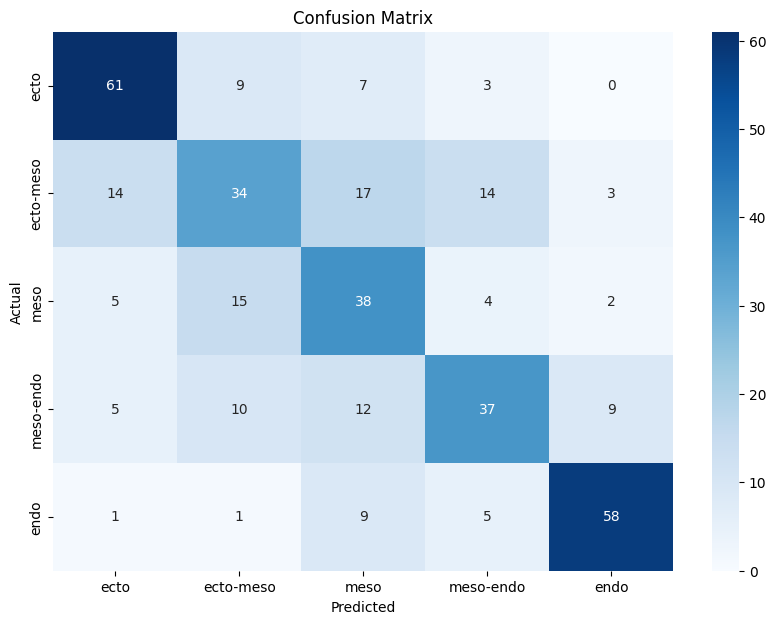

In [13]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '001'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

### ResNet50d

#### 001

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_001')
Accuracy: 0.627
Mean precision: 0.623
Mean recall: 0.623
---
ecto - precision: 0.651, recall: 0.863
ecto-meso - precision: 0.649, recall: 0.451
meso - precision: 0.625, recall: 0.469
meso-endo - precision: 0.507, recall: 0.507
endo - precision: 0.685, recall: 0.824


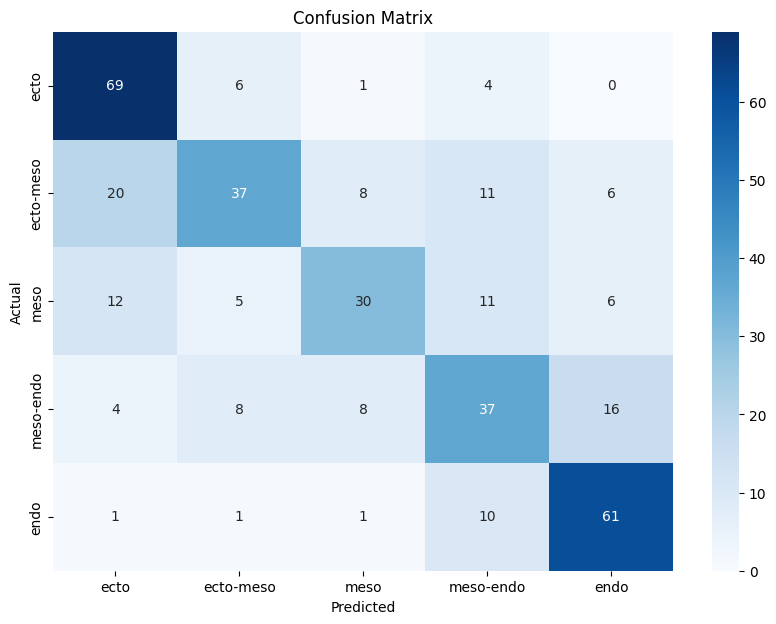

In [25]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '001'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 002

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_002')
Accuracy: 0.633
Mean precision: 0.653
Mean recall: 0.634
---
ecto - precision: 0.541, recall: 0.900
ecto-meso - precision: 0.719, recall: 0.280
meso - precision: 0.569, recall: 0.508
meso-endo - precision: 0.685, recall: 0.685
endo - precision: 0.753, recall: 0.795


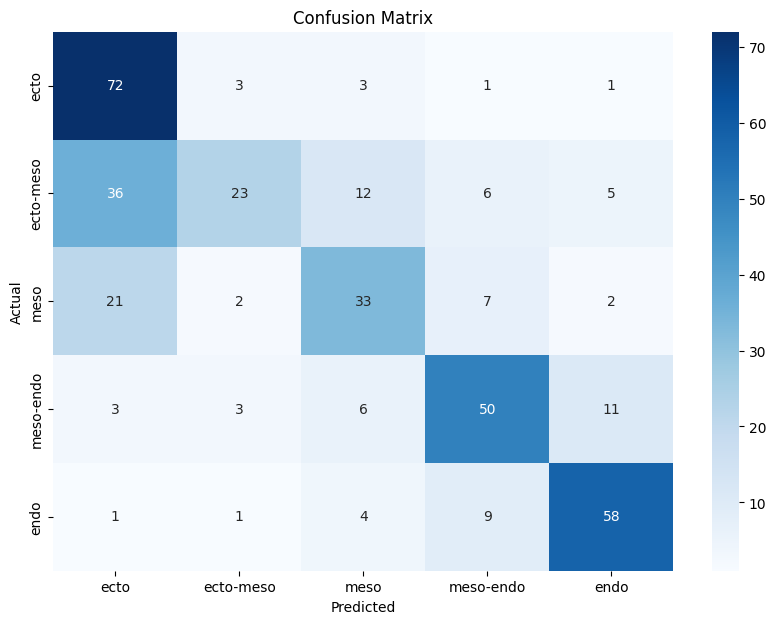

In [27]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '002'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 003

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_003')
Accuracy: 0.609
Mean precision: 0.605
Mean recall: 0.602
---
ecto - precision: 0.617, recall: 0.835
ecto-meso - precision: 0.517, recall: 0.542
meso - precision: 0.556, recall: 0.391
meso-endo - precision: 0.620, recall: 0.419
endo - precision: 0.714, recall: 0.822


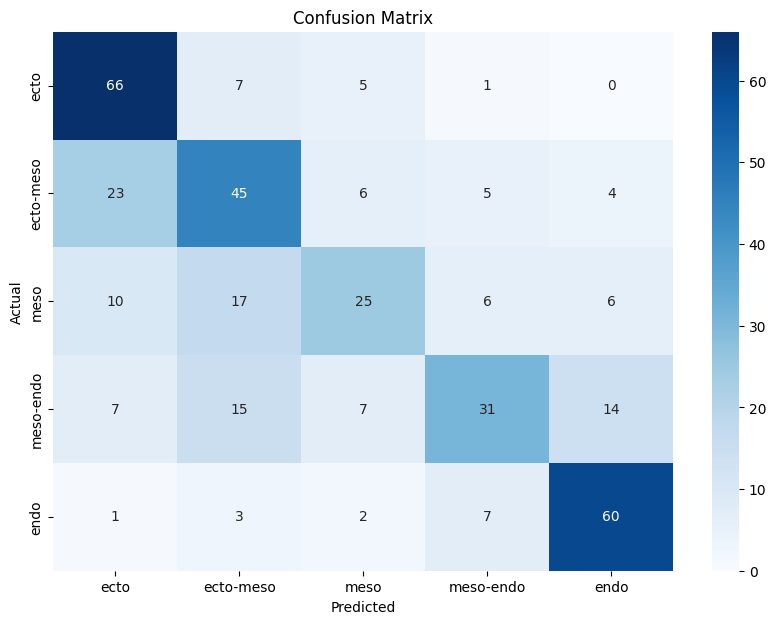

In [28]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '003'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 004

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 5, 6, 7, 8], val_folds=[9], test_folds=[4], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_004')
Accuracy: 0.536
Mean precision: 0.544
Mean recall: 0.530
---
ecto - precision: 0.654, recall: 0.671
ecto-meso - precision: 0.481, recall: 0.451
meso - precision: 0.600, recall: 0.277
meso-endo - precision: 0.434, recall: 0.493
endo - precision: 0.549, recall: 0.757


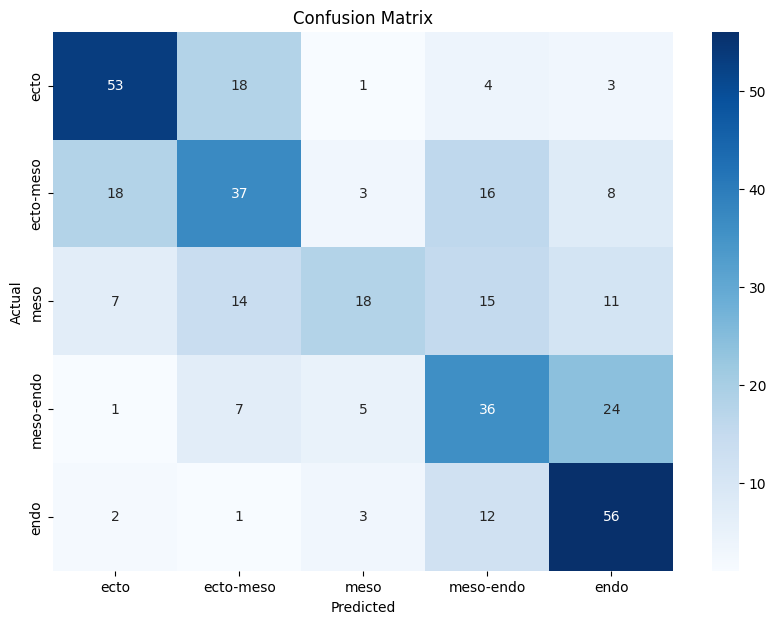

In [29]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '004'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 005

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 3, 4, 5, 6, 7, 9], val_folds=[2], test_folds=[8], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_005')
Accuracy: 0.617
Mean precision: 0.639
Mean recall: 0.617
---
ecto - precision: 0.541, recall: 0.911
ecto-meso - precision: 0.744, recall: 0.354
meso - precision: 0.538, recall: 0.538
meso-endo - precision: 0.629, recall: 0.527
endo - precision: 0.743, recall: 0.753


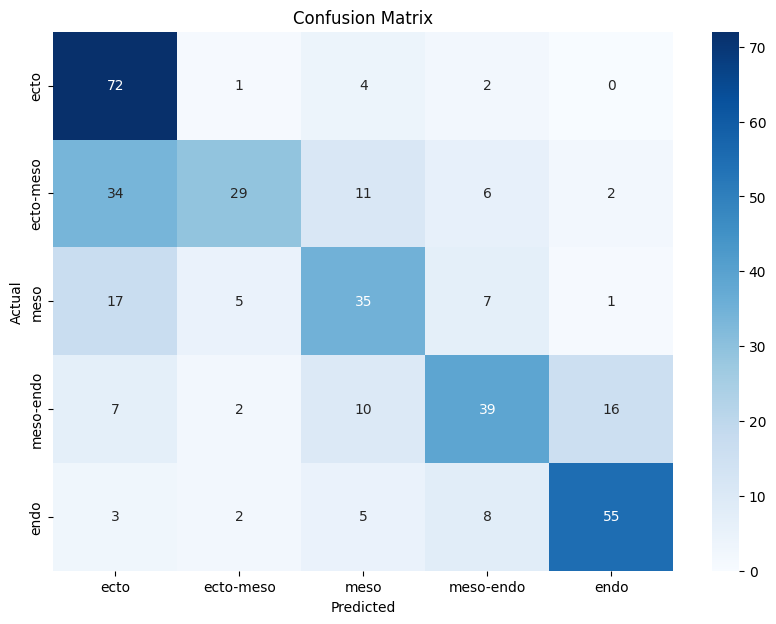

In [30]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '005'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 006

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 5, 7, 8, 9], val_folds=[0], test_folds=[6], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_006')
Accuracy: 0.542
Mean precision: 0.546
Mean recall: 0.538
---
ecto - precision: 0.476, recall: 0.873
ecto-meso - precision: 0.562, recall: 0.222
meso - precision: 0.423, recall: 0.333
meso-endo - precision: 0.523, recall: 0.466
endo - precision: 0.747, recall: 0.797


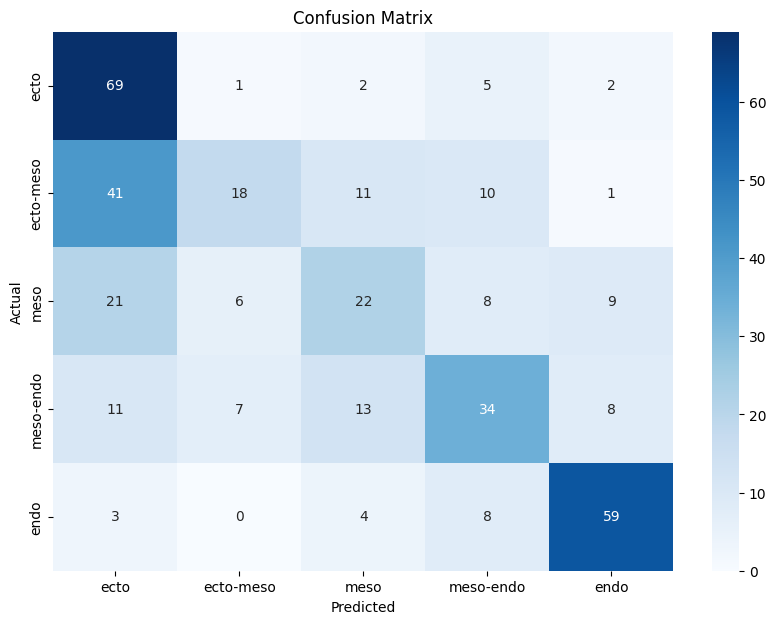

In [31]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '006'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 007

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_007')
Accuracy: 0.882
Mean precision: 0.887
Mean recall: 0.881
---
ecto - precision: 0.936, recall: 0.912
ecto-meso - precision: 0.783, recall: 0.878
meso - precision: 0.875, recall: 0.875
meso-endo - precision: 0.919, recall: 0.781
endo - precision: 0.922, recall: 0.959


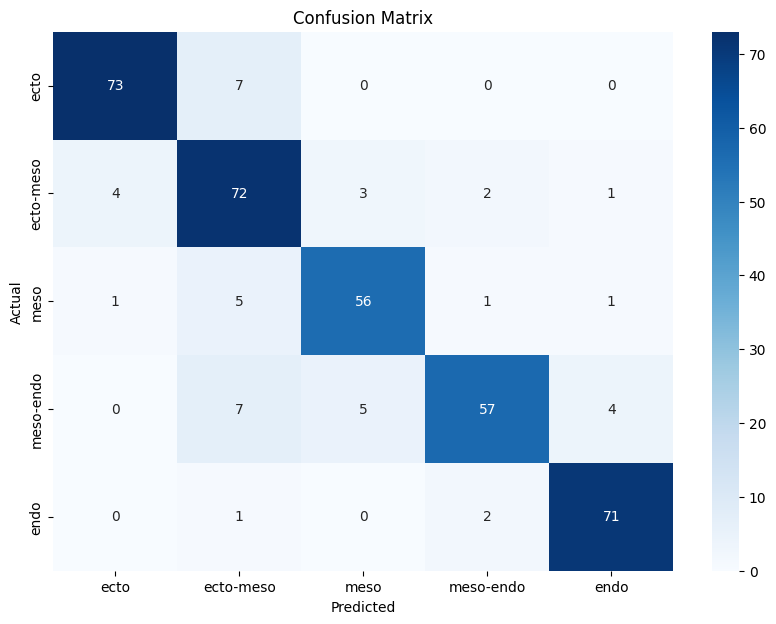

In [32]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '007'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 007 bis

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_007_bis')
Accuracy: 0.882
Mean precision: 0.887
Mean recall: 0.881
---
ecto - precision: 0.936, recall: 0.912
ecto-meso - precision: 0.783, recall: 0.878
meso - precision: 0.875, recall: 0.875
meso-endo - precision: 0.919, recall: 0.781
endo - precision: 0.922, recall: 0.959


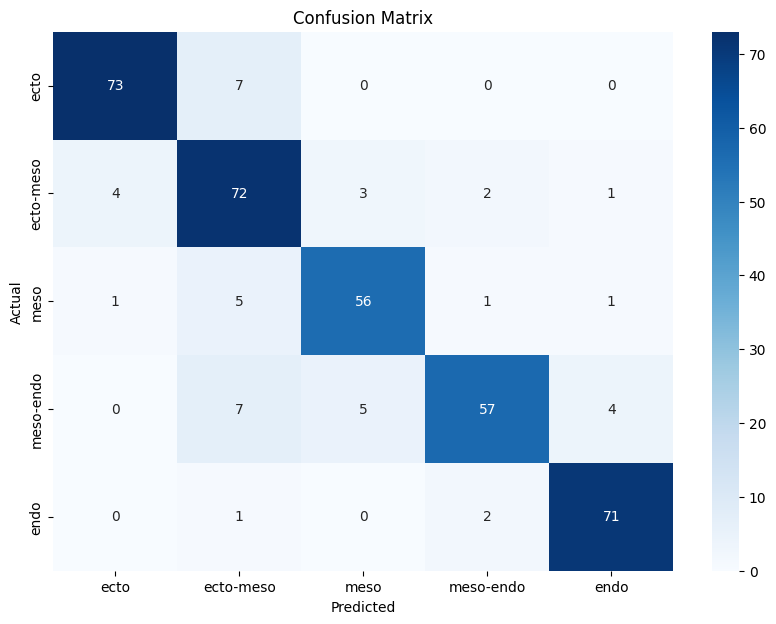

In [33]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '007_bis'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_007_bis')
Accuracy: 0.887
Mean precision: 0.888
Mean recall: 0.887
---
ecto - precision: 0.925, recall: 0.937
ecto-meso - precision: 0.826, recall: 0.866
meso - precision: 0.877, recall: 0.877
meso-endo - precision: 0.882, recall: 0.811
endo - precision: 0.932, recall: 0.945


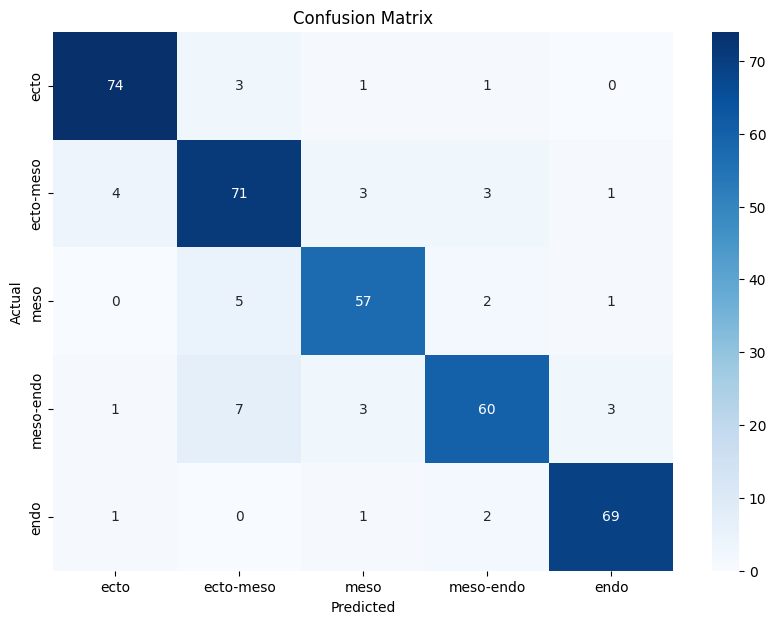

In [34]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '007_bis'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.val_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 008

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_008')
Accuracy: 0.842
Mean precision: 0.848
Mean recall: 0.844
---
ecto - precision: 0.781, recall: 0.938
ecto-meso - precision: 0.848, recall: 0.683
meso - precision: 0.915, recall: 0.831
meso-endo - precision: 0.829, recall: 0.863
endo - precision: 0.868, recall: 0.904


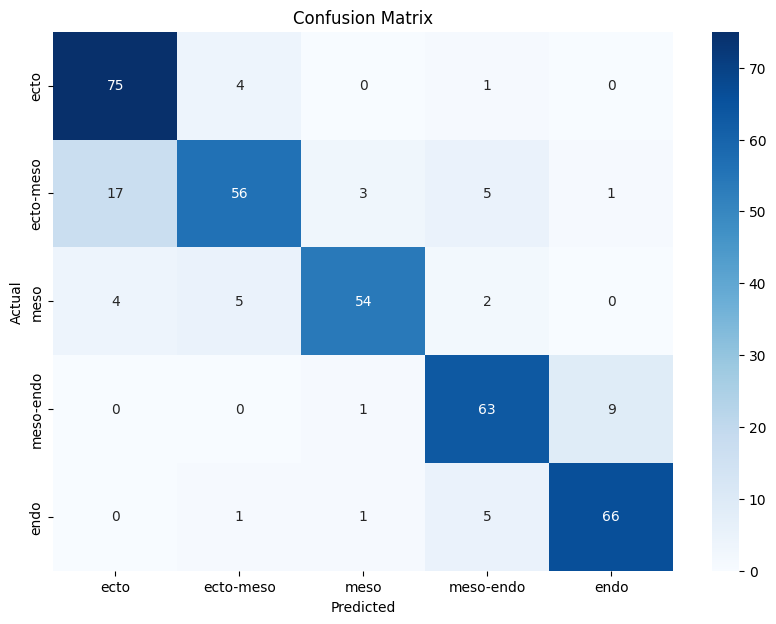

In [35]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '008'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 009

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_009')
Accuracy: 0.842
Mean precision: 0.846
Mean recall: 0.837
---
ecto - precision: 0.912, recall: 0.924
ecto-meso - precision: 0.777, recall: 0.880
meso - precision: 0.870, recall: 0.734
meso-endo - precision: 0.836, recall: 0.757
endo - precision: 0.833, recall: 0.890


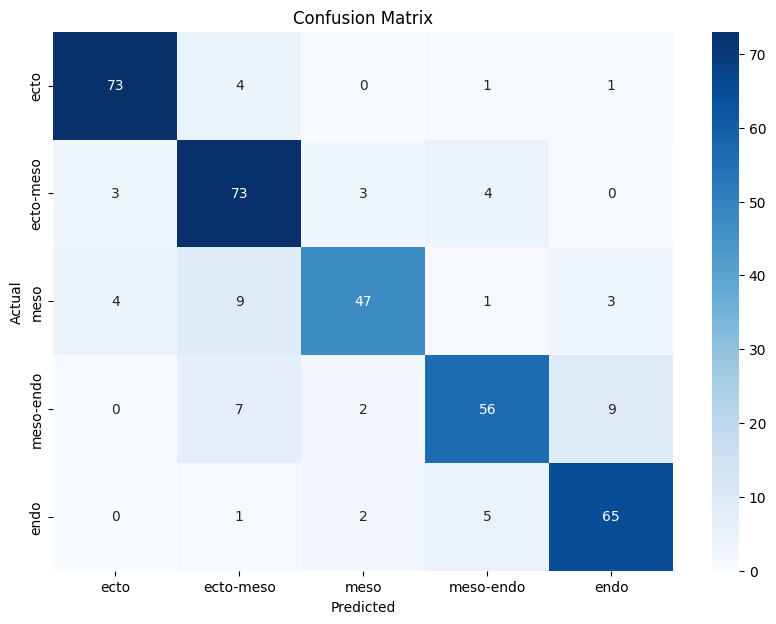

In [36]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '009'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 010

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 5, 6, 7, 8], val_folds=[9], test_folds=[4], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_010')
Accuracy: 0.799
Mean precision: 0.805
Mean recall: 0.797
---
ecto - precision: 0.828, recall: 0.911
ecto-meso - precision: 0.700, recall: 0.768
meso - precision: 0.836, recall: 0.785
meso-endo - precision: 0.839, recall: 0.644
endo - precision: 0.823, recall: 0.878


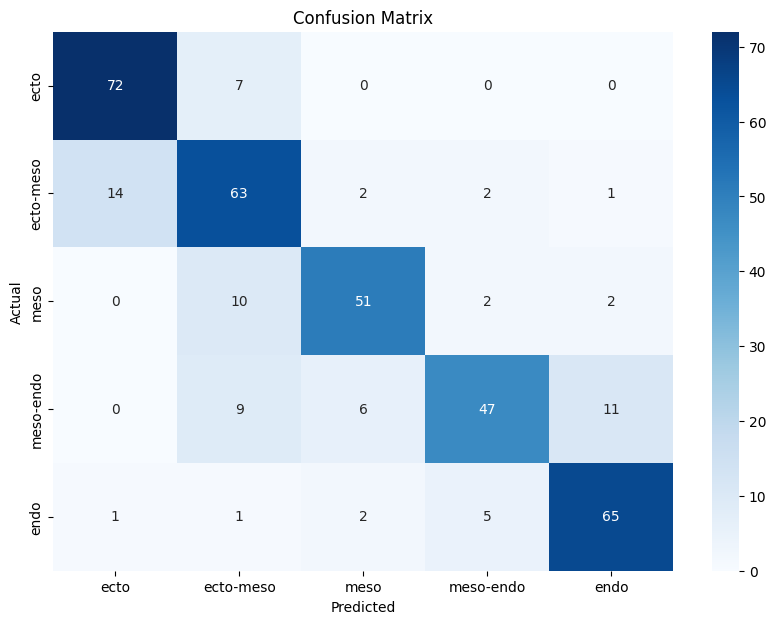

In [37]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '010'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 011

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 3, 4, 5, 6, 7, 9], val_folds=[2], test_folds=[8], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_011')
Accuracy: 0.874
Mean precision: 0.873
Mean recall: 0.872
---
ecto - precision: 0.915, recall: 0.949
ecto-meso - precision: 0.854, recall: 0.854
meso - precision: 0.869, recall: 0.815
meso-endo - precision: 0.847, recall: 0.824
endo - precision: 0.882, recall: 0.918


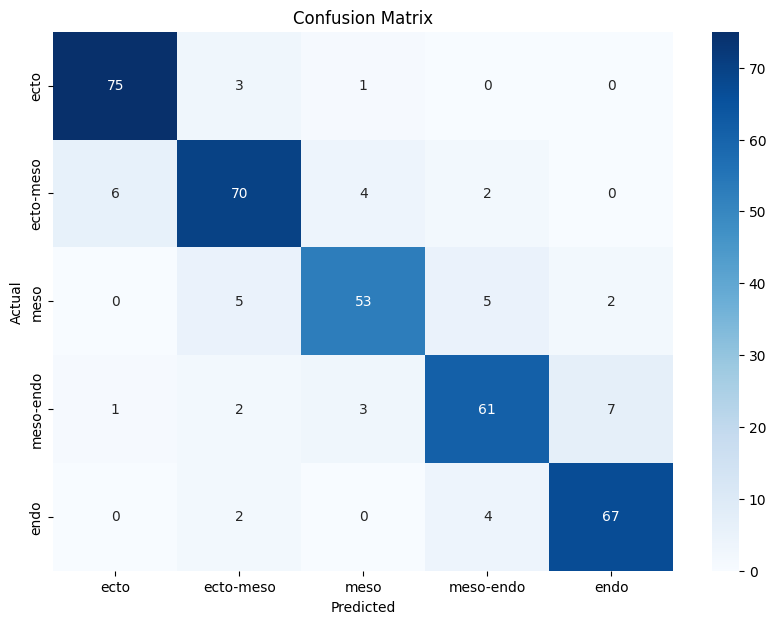

In [38]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '011'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 012

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 5, 7, 8, 9], val_folds=[0], test_folds=[6], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_012')
Accuracy: 0.802
Mean precision: 0.800
Mean recall: 0.799
---
ecto - precision: 0.923, recall: 0.911
ecto-meso - precision: 0.792, recall: 0.753
meso - precision: 0.797, recall: 0.712
meso-endo - precision: 0.721, recall: 0.671
endo - precision: 0.769, recall: 0.946


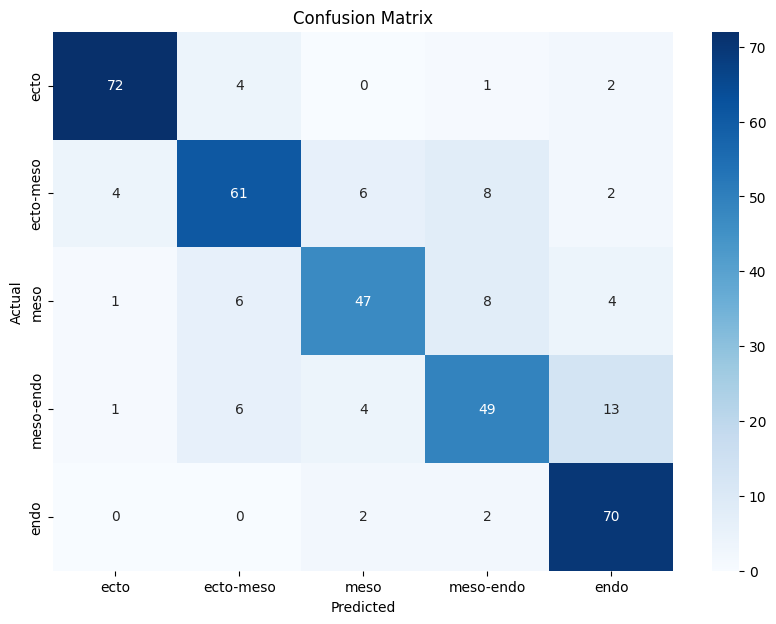

In [39]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '012'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 013

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_013')
Accuracy: 0.863
Mean precision: 0.868
Mean recall: 0.860
---
ecto - precision: 0.948, recall: 0.912
ecto-meso - precision: 0.763, recall: 0.902
meso - precision: 0.823, recall: 0.797
meso-endo - precision: 0.887, recall: 0.753
endo - precision: 0.920, recall: 0.932


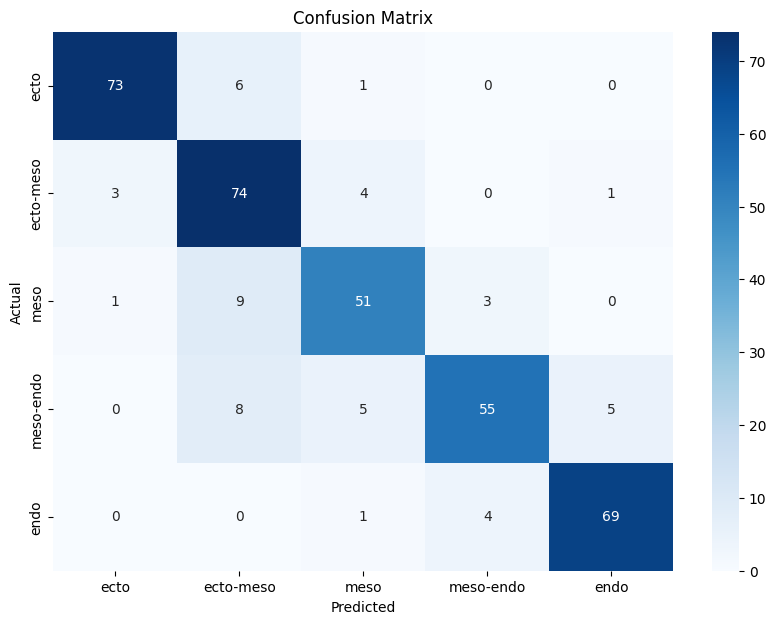

In [40]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '013'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 014

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_014')
Accuracy: 0.858
Mean precision: 0.858
Mean recall: 0.859
---
ecto - precision: 0.844, recall: 0.950
ecto-meso - precision: 0.843, recall: 0.720
meso - precision: 0.797, recall: 0.846
meso-endo - precision: 0.897, recall: 0.836
endo - precision: 0.908, recall: 0.945


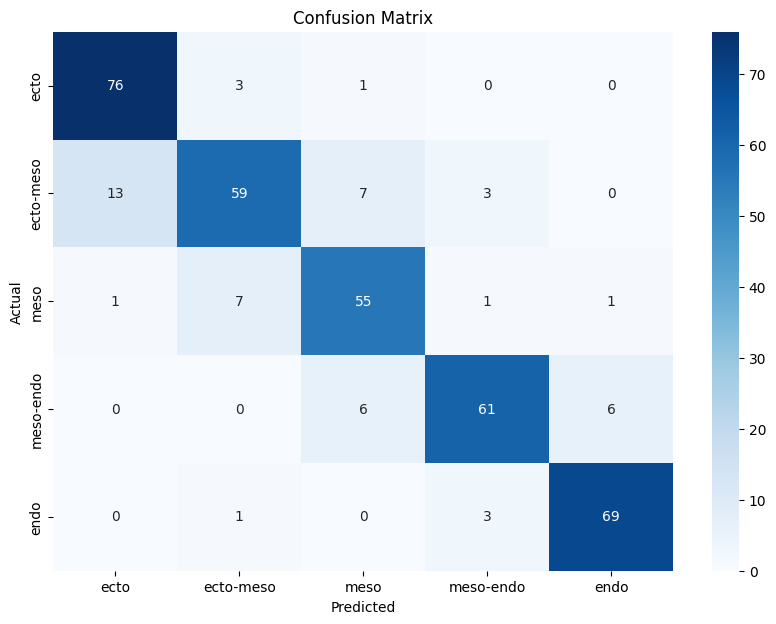

In [42]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '014'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 015

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_015')
Accuracy: 0.839
Mean precision: 0.847
Mean recall: 0.833
---
ecto - precision: 0.851, recall: 0.937
ecto-meso - precision: 0.787, recall: 0.892
meso - precision: 0.918, recall: 0.703
meso-endo - precision: 0.846, recall: 0.743
endo - precision: 0.833, recall: 0.890


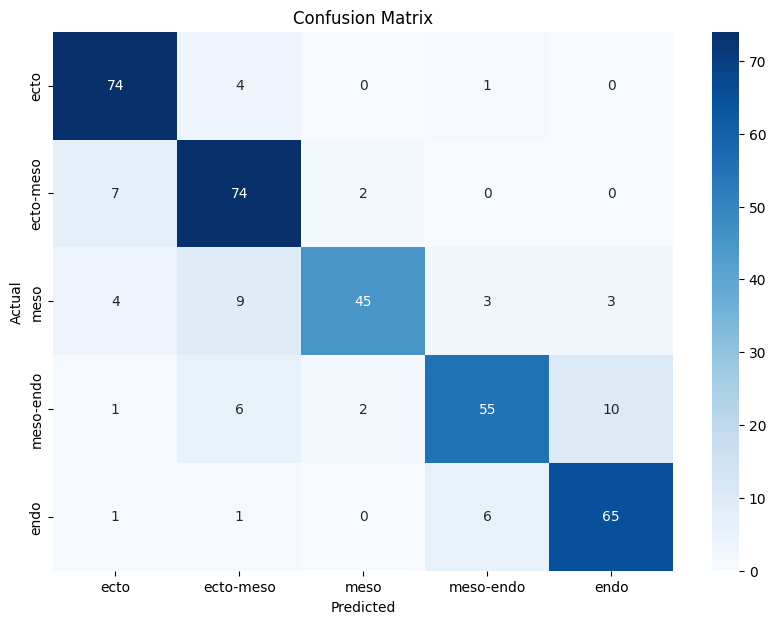

In [48]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '015'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 016

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 5, 6, 7, 8], val_folds=[9], test_folds=[4], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_016')
Accuracy: 0.842
Mean precision: 0.844
Mean recall: 0.841
---
ecto - precision: 0.815, recall: 0.949
ecto-meso - precision: 0.821, recall: 0.780
meso - precision: 0.869, recall: 0.815
meso-endo - precision: 0.821, recall: 0.753
endo - precision: 0.893, recall: 0.905


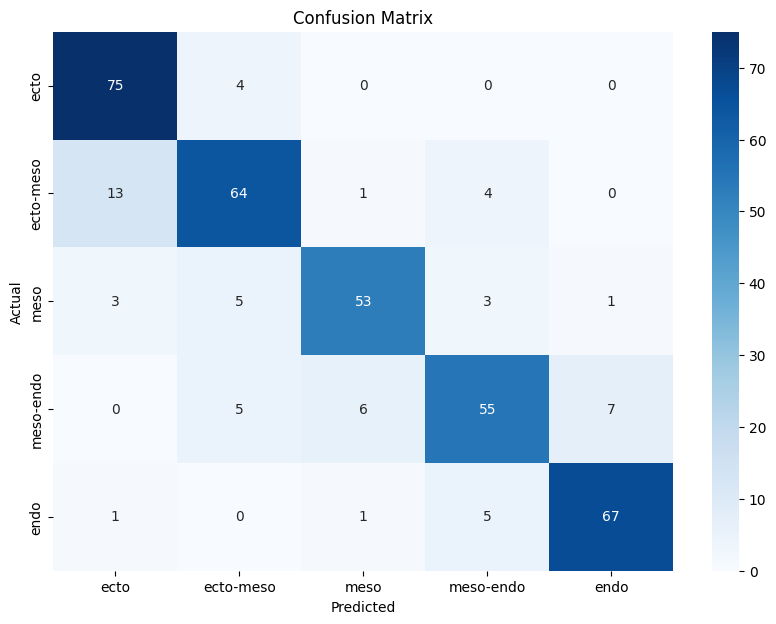

In [49]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '016'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 017

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 3, 4, 5, 6, 7, 9], val_folds=[2], test_folds=[8], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_017')
Accuracy: 0.879
Mean precision: 0.879
Mean recall: 0.877
---
ecto - precision: 0.907, recall: 0.987
ecto-meso - precision: 0.873, recall: 0.841
meso - precision: 0.881, recall: 0.800
meso-endo - precision: 0.849, recall: 0.838
endo - precision: 0.882, recall: 0.918


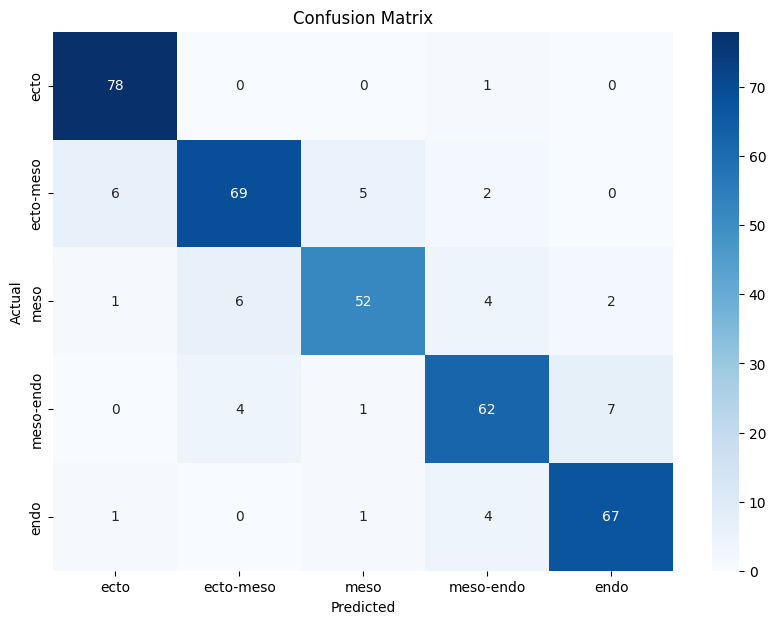

In [8]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '017'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 018

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 5, 7, 8, 9], val_folds=[0], test_folds=[6], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_018')
Accuracy: 0.855
Mean precision: 0.858
Mean recall: 0.854
---
ecto - precision: 0.855, recall: 0.899
ecto-meso - precision: 0.795, recall: 0.864
meso - precision: 0.889, recall: 0.848
meso-endo - precision: 0.846, recall: 0.753
endo - precision: 0.905, recall: 0.905


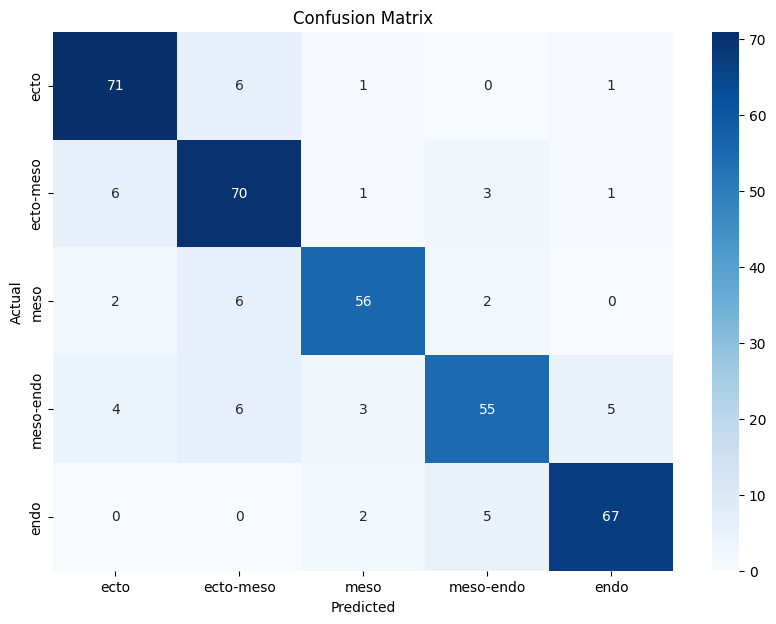

In [9]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '018'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 019

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_019')
Accuracy: 0.761
Mean precision: 0.755
Mean recall: 0.758
---
ecto - precision: 0.849, recall: 0.912
ecto-meso - precision: 0.696, recall: 0.671
meso - precision: 0.683, recall: 0.672
meso-endo - precision: 0.750, recall: 0.575
endo - precision: 0.798, recall: 0.959


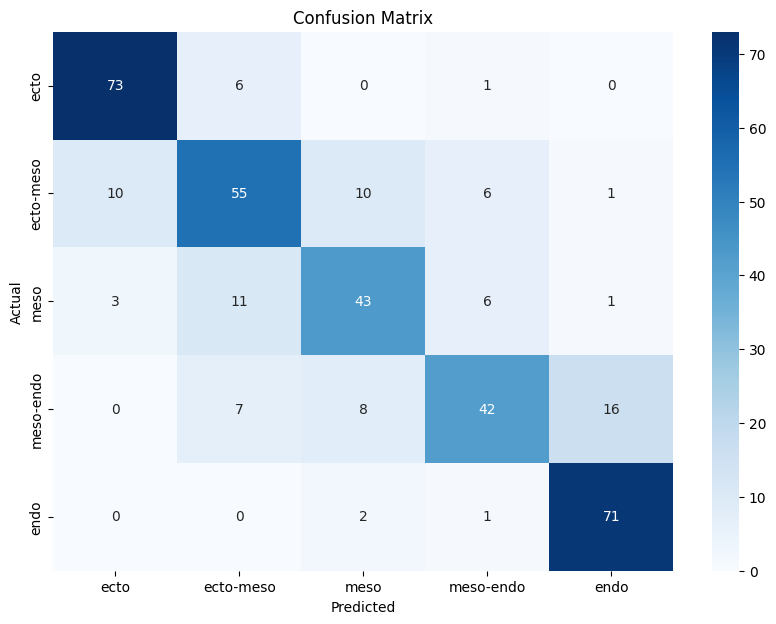

In [11]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '019'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 020

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_020')
Accuracy: 0.831
Mean precision: 0.830
Mean recall: 0.831
---
ecto - precision: 0.818, recall: 0.900
ecto-meso - precision: 0.806, recall: 0.707
meso - precision: 0.814, recall: 0.738
meso-endo - precision: 0.818, recall: 0.863
endo - precision: 0.896, recall: 0.945


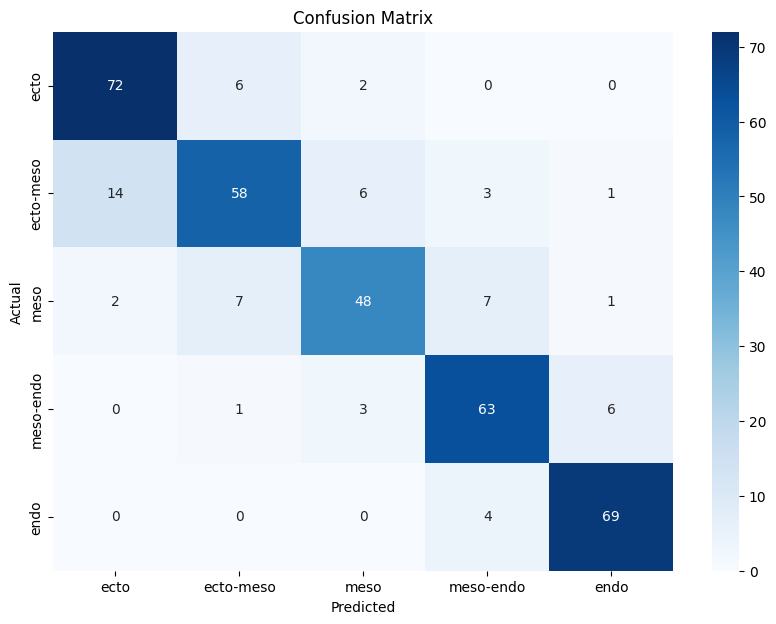

In [12]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '020'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 021

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_021')
Accuracy: 0.866
Mean precision: 0.872
Mean recall: 0.864
---
ecto - precision: 0.925, recall: 0.925
ecto-meso - precision: 0.780, recall: 0.866
meso - precision: 0.779, recall: 0.828
meso-endo - precision: 0.964, recall: 0.740
endo - precision: 0.910, recall: 0.959


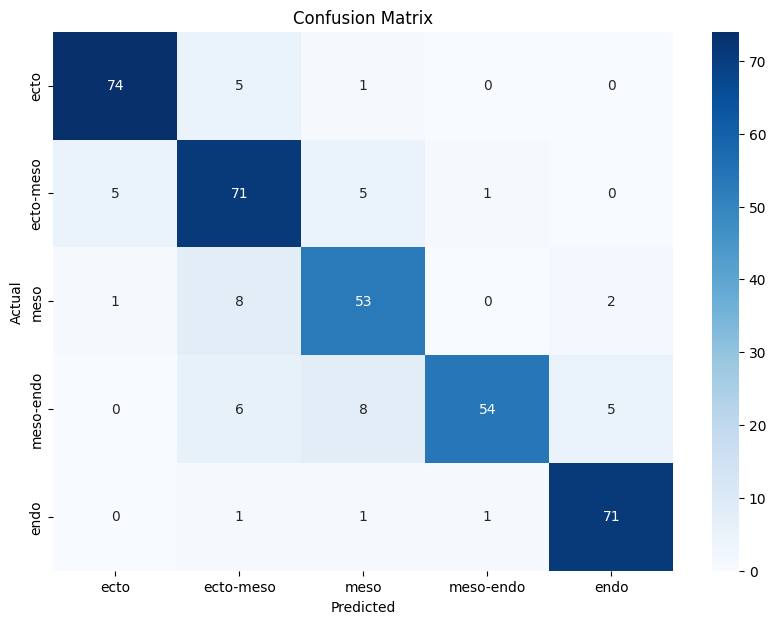

In [28]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '021'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_021')
Accuracy: 0.820
Mean precision: 0.822
Mean recall: 0.820
---
ecto - precision: 0.932, recall: 0.850
ecto-meso - precision: 0.736, recall: 0.780
meso - precision: 0.797, recall: 0.797
meso-endo - precision: 0.812, recall: 0.712
endo - precision: 0.835, recall: 0.959


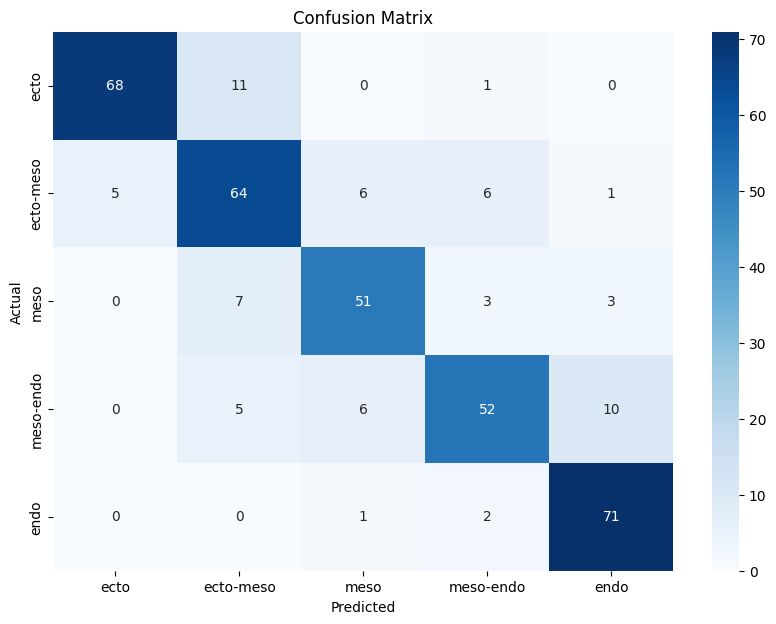

In [29]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '021'
weigths = 'model_best_loss.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 022

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_022')
Accuracy: 0.812
Mean precision: 0.817
Mean recall: 0.810
---
ecto - precision: 0.793, recall: 0.912
ecto-meso - precision: 0.824, recall: 0.683
meso - precision: 0.843, recall: 0.662
meso-endo - precision: 0.738, recall: 0.849
endo - precision: 0.885, recall: 0.945


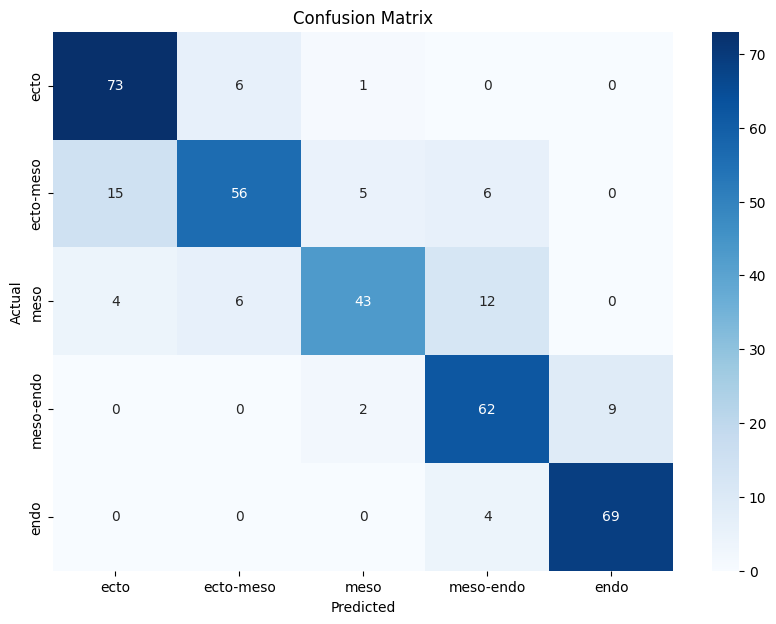

In [32]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '022'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 023

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_023')
Accuracy: 0.748
Mean precision: 0.742
Mean recall: 0.746
---
ecto - precision: 0.793, recall: 0.912
ecto-meso - precision: 0.681, recall: 0.598
meso - precision: 0.683, recall: 0.672
meso-endo - precision: 0.754, recall: 0.589
endo - precision: 0.798, recall: 0.959


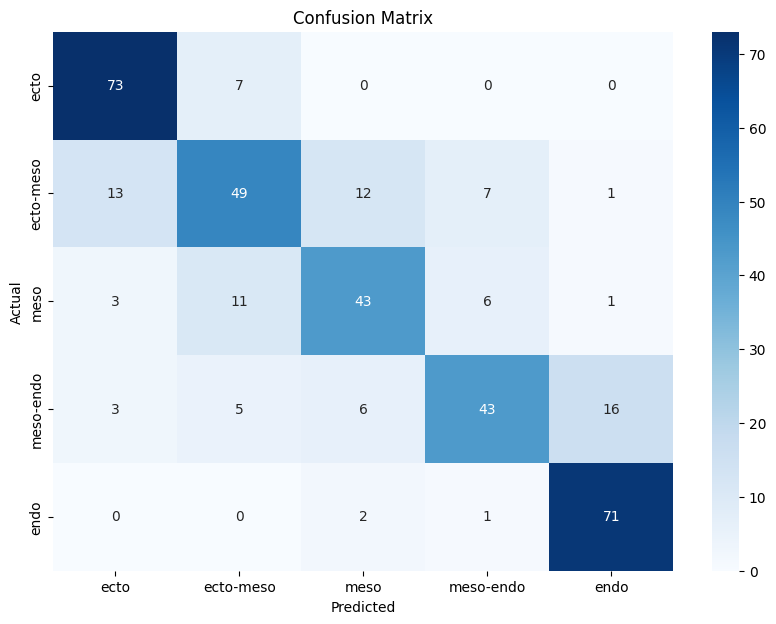

In [34]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '023'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 024

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_024')
Accuracy: 0.855
Mean precision: 0.854
Mean recall: 0.854
---
ecto - precision: 0.938, recall: 0.950
ecto-meso - precision: 0.786, recall: 0.805
meso - precision: 0.783, recall: 0.844
meso-endo - precision: 0.846, recall: 0.753
endo - precision: 0.919, recall: 0.919


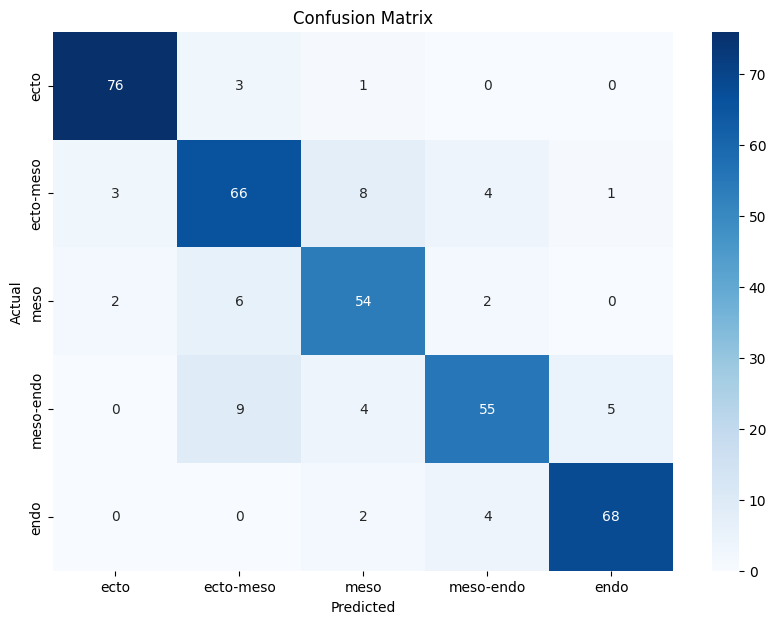

In [36]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '024'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.val_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 025

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_025')
Accuracy: 0.871
Mean precision: 0.873
Mean recall: 0.869
---
ecto - precision: 0.949, recall: 0.938
ecto-meso - precision: 0.814, recall: 0.854
meso - precision: 0.914, recall: 0.828
meso-endo - precision: 0.814, recall: 0.781
endo - precision: 0.875, recall: 0.946


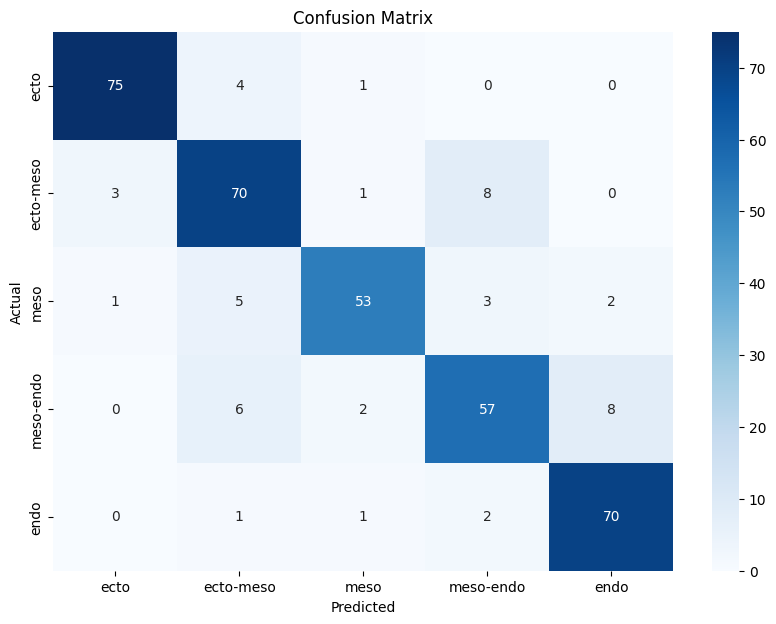

In [37]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '025'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 026

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_026')
Accuracy: 0.839
Mean precision: 0.842
Mean recall: 0.837
---
ecto - precision: 0.820, recall: 0.912
ecto-meso - precision: 0.790, recall: 0.780
meso - precision: 0.860, recall: 0.754
meso-endo - precision: 0.868, recall: 0.808
endo - precision: 0.872, recall: 0.932


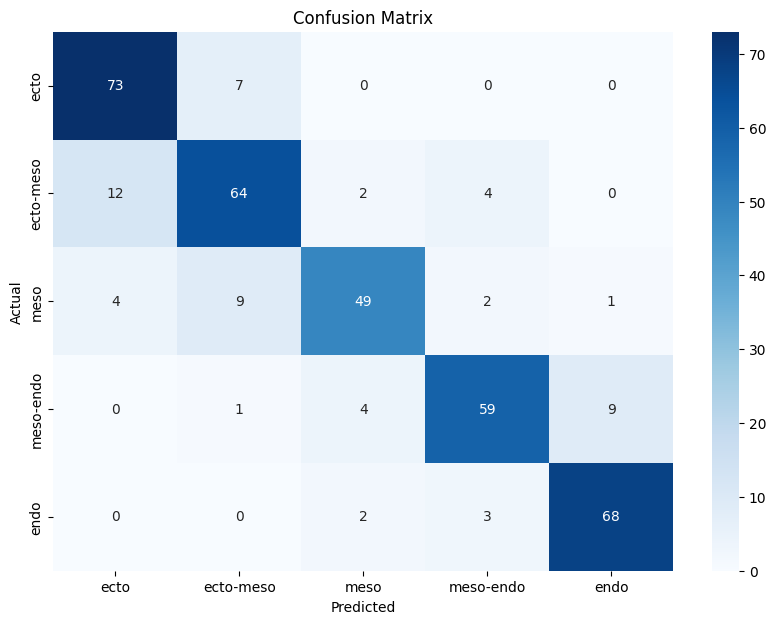

In [38]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '026'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 027

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_027')
Accuracy: 0.861
Mean precision: 0.870
Mean recall: 0.857
---
ecto - precision: 0.933, recall: 0.875
ecto-meso - precision: 0.752, recall: 0.927
meso - precision: 0.879, recall: 0.797
meso-endo - precision: 0.900, recall: 0.740
endo - precision: 0.886, recall: 0.946


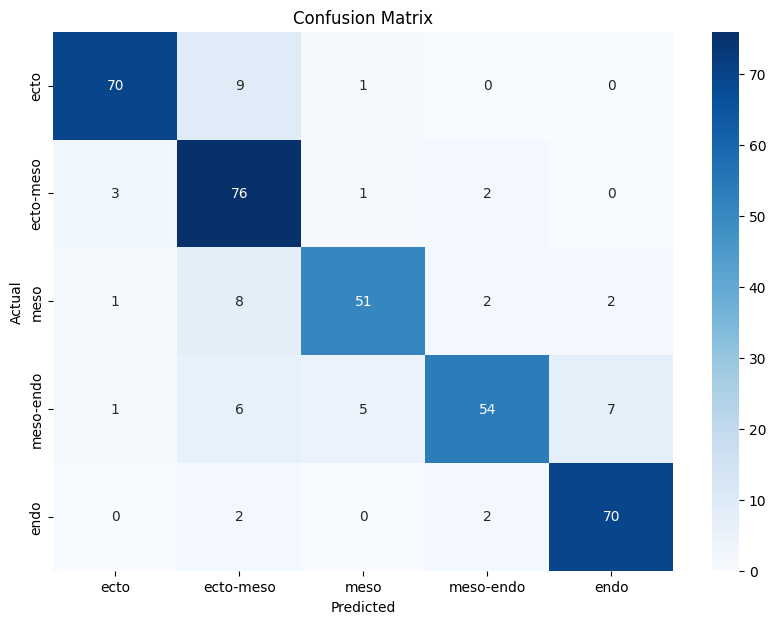

In [39]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '027'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 028

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_028')
Accuracy: 0.847
Mean precision: 0.853
Mean recall: 0.849
---
ecto - precision: 0.773, recall: 0.938
ecto-meso - precision: 0.866, recall: 0.707
meso - precision: 0.885, recall: 0.831
meso-endo - precision: 0.873, recall: 0.849
endo - precision: 0.870, recall: 0.918


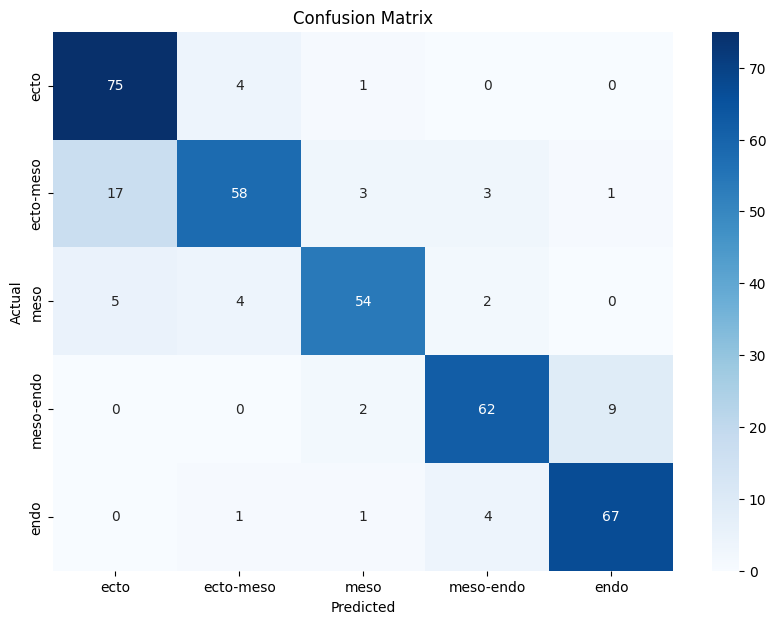

In [40]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '028'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 029

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_029')
Accuracy: 0.855
Mean precision: 0.857
Mean recall: 0.853
---
ecto - precision: 0.925, recall: 0.925
ecto-meso - precision: 0.791, recall: 0.829
meso - precision: 0.897, recall: 0.812
meso-endo - precision: 0.809, recall: 0.753
endo - precision: 0.864, recall: 0.946


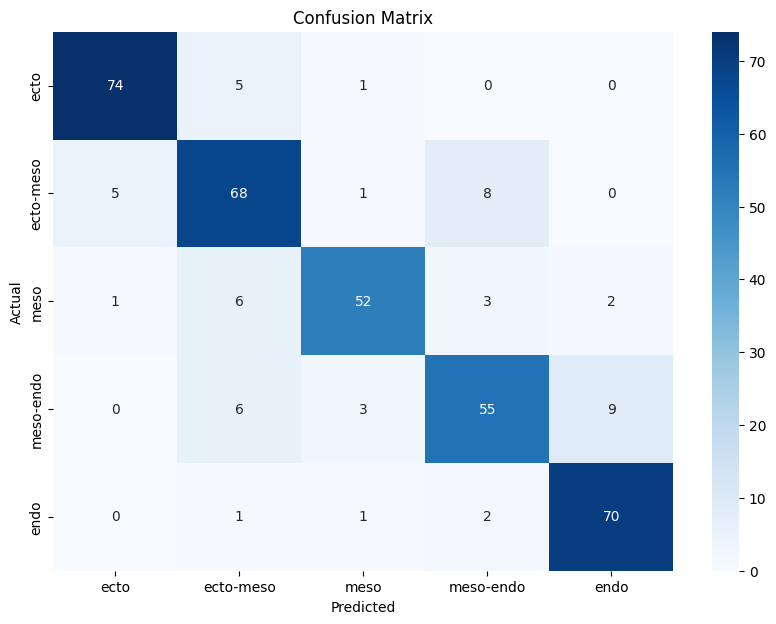

In [41]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '029'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 030

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_030')
Accuracy: 0.839
Mean precision: 0.843
Mean recall: 0.837
---
ecto - precision: 0.830, recall: 0.912
ecto-meso - precision: 0.790, recall: 0.780
meso - precision: 0.889, recall: 0.738
meso-endo - precision: 0.833, recall: 0.822
endo - precision: 0.872, recall: 0.932


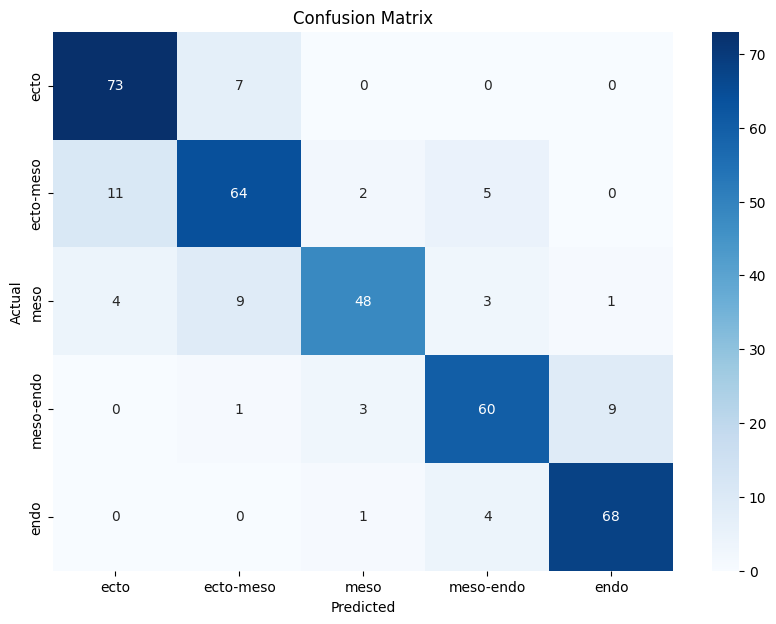

In [42]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '030'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

### ResNet33ts

#### 001

Namespace(model_name='resnet33ts', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet33ts_001')
Accuracy: 0.619
Mean precision: 0.626
Mean recall: 0.624
---
ecto - precision: 0.644, recall: 0.812
ecto-meso - precision: 0.674, recall: 0.354
meso - precision: 0.556, recall: 0.703
meso-endo - precision: 0.646, recall: 0.425
endo - precision: 0.610, recall: 0.824


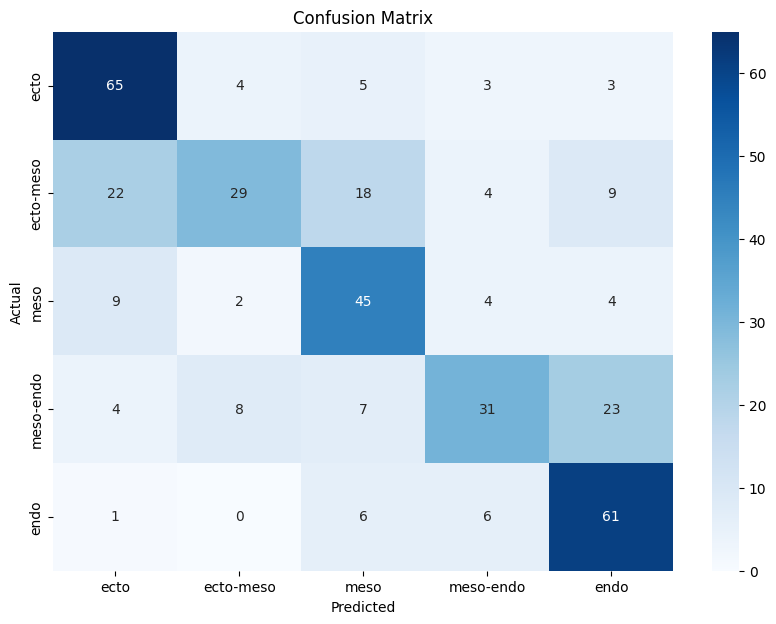

In [14]:
# Variables
model_name = 'resnet33ts'
log_name = model_name + '_' + '001'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)